In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Parameters
img_height, img_width = 224, 224
batch_size = 32
epochs = 10
train_dir = '/content/drive/MyDrive/data/train'
validation_dir = '/content/drive/MyDrive/data/test'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Data preparation using image_dataset_from_directory
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical'
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical'
)

# **Determine the correct number of classes**
num_classes = len(train_dataset.class_names)  # Get the number of classes from the dataset



Found 15590 files belonging to 23 classes.
Found 4029 files belonging to 23 classes.


In [ ]:
# Load the pre-trained ResNet50 model + higher level layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
# **Use num_classes in the final Dense layer**
predictions = Dense(num_classes, activation='softmax')(x)

In [ ]:
# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)


In [ ]:
# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [ ]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

# Train the model with callbacks
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=validation_dataset,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/10
488/488 [==============================] - 366s 738ms/step - loss: 2.4402 - accuracy: 0.2999 - val_loss: 2.1978 - val_accuracy: 0.3569 - lr: 0.0010
Epoch 2/10
488/488 [==============================] - 345s 705ms/step - loss: 1.9901 - accuracy: 0.4012 - val_loss: 2.0687 - val_accuracy: 0.3904 - lr: 0.0010
Epoch 3/10
488/488 [==============================] - 344s 704ms/step - loss: 1.7472 - accuracy: 0.4675 - val_loss: 2.0370 - val_accuracy: 0.4006 - lr: 0.0010
Epoch 4/10
488/488 [==============================] - 333s 683ms/step - loss: 1.5126 - accuracy: 0.5336 - val_loss: 2.0571 - val_accuracy: 0.4068 - lr: 0.0010
Epoch 5/10
488/488 [==============================] - 329s 673ms/step - loss: 1.3067 - accuracy: 0.5941 - val_loss: 2.1243 - val_accuracy: 0.4157 - lr: 0.0010
Epoch 6/10
488/488 [==============================] - 334s 683ms/step - loss: 1.1051 - accuracy: 0.6574 - val_loss: 2.1288 - val_accuracy: 0.4192 - lr: 0.0010
Epoch 7/10
488/488 [==========================

In [ ]:

model_path = '/content/drive/MyDrive/demoimg_skinvmax/resnet50_image_classifier2.keras'
# Save the model
model.save(model_path)
print("Model training complete and saved in Keras format.")


Model training complete and saved in Keras format.


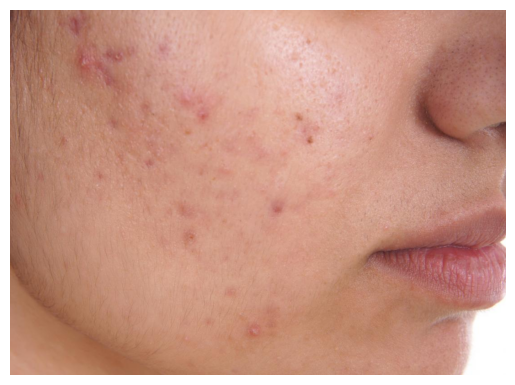

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
# Define the image path
img_path = '/content/drive/MyDrive/demoimg_skinvmax/acnedemo.jpg'
# Open the image file
img = Image.open(img_path)

# Display the image
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import os

# Define paths
model_path = '/content/drive/MyDrive/demoimg_skinvmax/resnet50_image_classifier2.keras'
img_path = '/content/drive/MyDrive/demoimg_skinvmax/acnedemo.jpg'

# Load the trained model
model = tf.keras.models.load_model(model_path)

# Hardcoded class names (replace with actual class names)
class_names = ['Acne and Rosacea Photos', 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Atopic Dermatitis Photos', 'Bullous Disease Photos', 'Cellulitis Impetigo and other Bacterial Infections', 'Eczema Photos', 'Exanthems and Drug Eruptions', 'Hair Loss Photos Alopecia and other Hair Diseases', 'Herpes HPV and other STDs Photos', 'Light Diseases and Disorders of Pigmentation', 'Lupus and other Connective Tissue diseases', 'Melanoma Skin Cancer Nevi and Moles', 'Nail Fungus and other Nail Disease', 'Poison Ivy Photos and other Contact Dermatitis',
               'Psoriasis pictures Lichen Planus and related diseases', 'Scabies Lyme Disease and other Infestations and Bites', 'Seborrheic Keratoses and other Benign Tumors', 'Systemic Disease', 'Tinea Ringworm Candidiasis and other Fungal Infections', 'Urticaria Hives', 'Vascular Tumors', 'Vasculitis Photos', 'Warts Molluscum and other Viral Infections']

# Check if the image file exists
if not os.path.isfile(img_path):
    raise FileNotFoundError(f"The file at {img_path} does not exist.")

# Preprocess the image
img_height, img_width = 224, 224  # Same as used in training
img = image.load_img(img_path, target_size=(img_height, img_width))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = tf.keras.applications.resnet50.preprocess_input(img_array)  # Preprocess for ResNet50

# Make predictions
predictions = model.predict(img_array)

# Decode the predictions
predicted_class = np.argmax(predictions, axis=-1)
predicted_label = class_names[predicted_class[0]]

print(f"Predicted label: {predicted_label}")


1/1 [==============================] - 1s 955ms/step
Predicted label: Acne and Rosacea Photos
